#📌 Extracción

In [1]:
# 📌 Paso 1: Importar librerías necesarias
import pandas as pd
import requests

# 📌 Paso 2: Definir la URL del archivo JSON en formato raw
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"

# 📌 Paso 3: Realizar la solicitud GET para obtener los datos
response = requests.get(url)

# 📌 Paso 4: Convertir el contenido JSON en un DataFrame de pandas
data_json = response.json()
df = pd.DataFrame(data_json)

# 📌 Paso 5: Mostrar las primeras filas para verificar la carga
df.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


#🔧 Transformación

In [2]:
# Ver columnas y tipos de datos
df.info()

# Alternativamente
df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB


,0
customerID,object
Churn,object
customer,object
phone,object
internet,object
account,object


In [6]:
# Verificar tipos de datos detalladamente
df.applymap(type).nunique()

/tmp/ipython-input-3702349118.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.applymap(type).nunique()


,0
customerID,1
Churn,1
customer,1
phone,1
internet,1
account,1


In [10]:
# Verificar el tipo de cada celda en cada columna
for col in df.columns:
    tipos = df[col].apply(type).unique()
    print(f"{col}: {tipos}")

customerID: [<class 'str'>]
Churn: [<class 'str'>]
customer: [<class 'dict'>]
phone: [<class 'dict'>]
internet: [<class 'dict'>]
account: [<class 'dict'>]


In [11]:
# Normalizar columnas anidadas
from pandas import json_normalize

# Normalizar cada columna que contenga diccionarios
for col in ['customer', 'phone', 'internet', 'account']:
    if df[col].apply(lambda x: isinstance(x, dict)).all():
        normalized = json_normalize(df[col])
        normalized.columns = [f"{col}_{subcol}" for subcol in normalized.columns]
        df = pd.concat([df.drop(columns=col), normalized], axis=1)

In [12]:
# Ahora sí puedes verificar duplicados
print("🔍 Duplicados después de normalizar:")
print(df.duplicated().sum())

🔍 Duplicados después de normalizar:
0


In [14]:
from pandas import json_normalize

def normalize_nested_columns(df, nested_cols):
    for col in nested_cols:
        if col in df.columns:
            if df[col].apply(lambda x: isinstance(x, dict)).all():
                normalized = json_normalize(df[col])
                normalized.columns = [f"{col}_{subcol}" for subcol in normalized.columns]
                df = pd.concat([df.drop(columns=col), normalized], axis=1)
    return df

# Lista de columnas que podrían estar anidadas
nested_columns = ['customer', 'phone', 'internet', 'account']
df = normalize_nested_columns(df, nested_columns)

In [15]:
# Verificamos que la columna de facturación mensual exista
if 'account_MonthlyCharges' in df.columns:
    # Cálculo aproximado: mensual / 30.44 días
    df['Cuentas_Diarias'] = df['account_MonthlyCharges'] / 30.44

    # Vista previa
    print(df[['account_MonthlyCharges', 'Cuentas_Diarias']].head())
else:
    print("❌ La columna 'account_MonthlyCharges' no fue encontrada.")

❌ La columna 'account_MonthlyCharges' no fue encontrada.


In [16]:
# Convertir 'Churn' a binario
df['Churn'] = df['Churn'].map({'Sí': 1, 'No': 0})

# Convertir otras columnas similares si existen
binarias = ['customer_Partner', 'customer_Dependents', 'account_PaperlessBilling']
for col in binarias:
    if col in df.columns:
        df[col] = df[col].map({'Sí': 1, 'No': 0})


In [17]:
# Renombrar columnas clave
df.rename(columns={
    'account_MonthlyCharges': 'Cargos_Mensuales',
    'account_TotalCharges': 'Cargos_Totales',
    'account_PaymentMethod': 'Metodo_Pago',
    'internet_InternetService': 'Tipo_Internet',
    'contract_Contract': 'Tipo_Contrato'
}, inplace=True)

In [18]:
print("📋 Columnas después de estandarización:")
print(df.columns.tolist())

print("\n🔍 Vista previa:")
print(df.head())

📋 Columnas después de estandarización:
['customerID', 'Churn', 'customer_gender', 'customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents', 'customer_tenure', 'phone_PhoneService', 'phone_MultipleLines', 'Tipo_Internet', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'Metodo_Pago', 'account_Charges.Monthly', 'account_Charges.Total']

🔍 Vista previa:
   customerID  Churn customer_gender  customer_SeniorCitizen  \
0  0002-ORFBO    0.0          Female                       0   
1  0003-MKNFE    0.0            Male                       0   
2  0004-TLHLJ    NaN            Male                       0   
3  0011-IGKFF    NaN            Male                       1   
4  0013-EXCHZ    NaN          Female                       1   

   customer_Partner  customer_Dependents  customer_tenure phone_PhoneService  \
0             

#📊 Carga y análisis

In [20]:
print("📋 Columnas actuales:")
print(df.columns.tolist())

📋 Columnas actuales:
['customerID', 'Churn', 'customer_gender', 'customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents', 'customer_tenure', 'phone_PhoneService', 'phone_MultipleLines', 'Tipo_Internet', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'Metodo_Pago', 'account_Charges.Monthly', 'account_Charges.Total']


In [21]:
numericas = [
    'customer_tenure',
    'account_MonthlyCharges',
    'account_TotalCharges',
    'Cuentas_Diarias'  # solo si ya la creaste
]

In [23]:
print("📋 Columnas disponibles en el DataFrame:")
print(df.columns.tolist())

📋 Columnas disponibles en el DataFrame:
['customerID', 'Churn', 'customer_gender', 'customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents', 'customer_tenure', 'phone_PhoneService', 'phone_MultipleLines', 'Tipo_Internet', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'Metodo_Pago', 'account_Charges.Monthly', 'account_Charges.Total']


In [24]:
# Detectar columnas numéricas automáticamente
numericas = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Mostrar análisis descriptivo
df[numericas].describe().T

,count,mean,std,min,25%,50%,75%,max
Churn,5174.0,0.000000,0.000000,0.00,0.000,0.0,0.000,0.00
customer_SeniorCitizen,7267.0,0.162653,0.369074,0.00,0.000,0.0,0.000,1.00
customer_Partner,3749.0,0.000000,0.000000,0.00,0.000,0.0,0.000,0.00
customer_Dependents,5086.0,0.000000,0.000000,0.00,0.000,0.0,0.000,0.00
customer_tenure,7267.0,32.346498,24.571773,0.00,9.000,29.0,55.000,72.00
account_PaperlessBilling,2956.0,0.000000,0.000000,0.00,0.000,0.0,0.000,0.00
account_Charges.Monthly,7267.0,64.720098,30.129572,18.25,35.425,70.3,89.875,118.75


In [25]:
# Filtrar columnas relevantes si existen
relevantes = [col for col in numericas if 'tenure' in col or 'Charges' in col or 'Cuentas_Diarias' in col]
df[relevantes].describe().T

,count,mean,std,min,25%,50%,75%,max
customer_tenure,7267.0,32.346498,24.571773,0.00,9.000,29.0,55.000,72.00
account_Charges.Monthly,7267.0,64.720098,30.129572,18.25,35.425,70.3,89.875,118.75


In [26]:
# 📌 Detectar columnas numéricas automáticamente
numericas = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 📌 Análisis descriptivo general
print("📊 Estadísticas generales:")
print(df[numericas].describe().T)

# 📌 Mediana de cada variable
print("\n📍 Medianas:")
print(df[numericas].median())

# 📌 Desviación estándar
print("\n📍 Desviaciones estándar:")
print(df[numericas].std())

# 📌 Percentiles personalizados
print("\n📍 Percentiles (10%, 25%, 50%, 75%, 90%):")
print(df[numericas].quantile([0.1, 0.25, 0.5, 0.75, 0.9]).T)

📊 Estadísticas generales:
                           count       mean        std    min     25%   50%  \
Churn                     5174.0   0.000000   0.000000   0.00   0.000   0.0   
customer_SeniorCitizen    7267.0   0.162653   0.369074   0.00   0.000   0.0   
customer_Partner          3749.0   0.000000   0.000000   0.00   0.000   0.0   
customer_Dependents       5086.0   0.000000   0.000000   0.00   0.000   0.0   
customer_tenure           7267.0  32.346498  24.571773   0.00   9.000  29.0   
account_PaperlessBilling  2956.0   0.000000   0.000000   0.00   0.000   0.0   
account_Charges.Monthly   7267.0  64.720098  30.129572  18.25  35.425  70.3   

                             75%     max  
Churn                      0.000    0.00  
customer_SeniorCitizen     0.000    1.00  
customer_Partner           0.000    0.00  
customer_Dependents        0.000    0.00  
customer_tenure           55.000   72.00  
account_PaperlessBilling   0.000    0.00  
account_Charges.Monthly   89.875  118.75

/tmp/ipython-input-345839718.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Churn', palette='Set2')


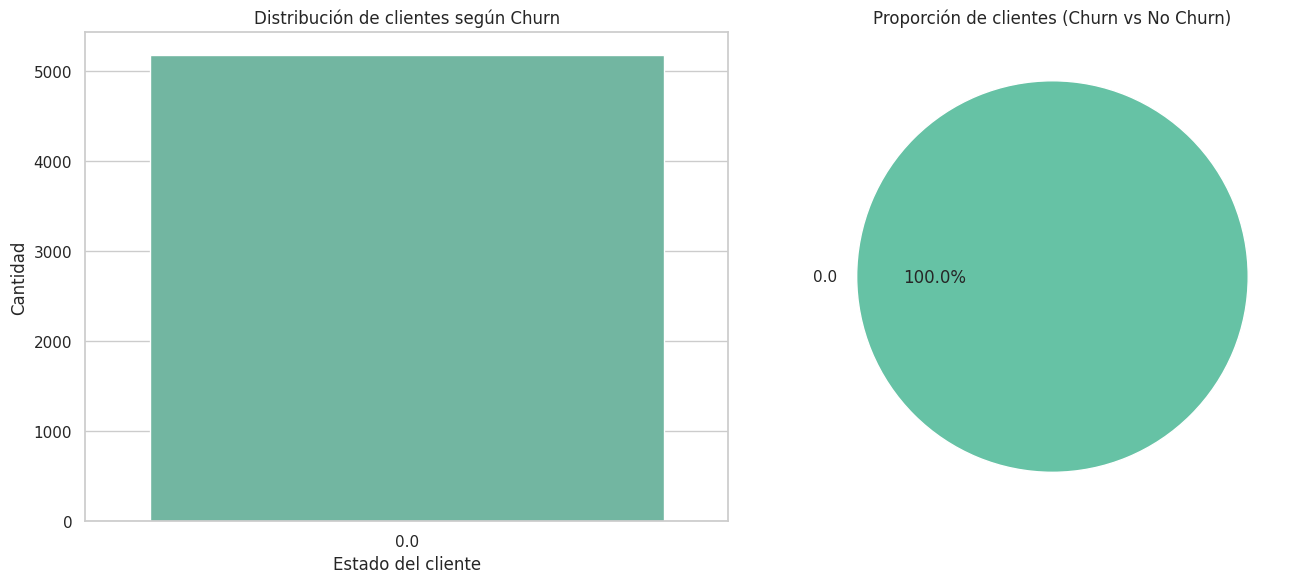

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

# 🔹 Gráfico de barras
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='Churn', palette='Set2')
plt.title('Distribución de clientes según Churn')
plt.xlabel('Estado del cliente')
plt.ylabel('Cantidad')

# 🔸 Gráfico de pastel
plt.subplot(1, 2, 2)
churn_counts = df['Churn'].value_counts()
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title('Proporción de clientes (Churn vs No Churn)')

plt.tight_layout()
plt.show()

#📄Informe final